In [18]:
import pandas as pd
import sys
import re
import os

import pathlib
import pickle
import string
import numpy as np

import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords

from sklearn.datasets import load_files
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer as CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer as TfidfTransformer
from sklearn.pipeline import make_pipeline

import lime
import lime.lime_tabular
from lime import lime_text
from lime.lime_text import LimeTextExplainer

%matplotlib inline

<h2>1. Reading the dataset</h2>

In [19]:
def get_articles() -> pd.DataFrame:
    """
    data source: https://github.com/katakonst/sentiment-analysis-tensorflow/tree/master/datasets
    :return: the dataset containing labeled articles
    """
 
    path = pathlib.Path('C:/Users/mandr/Desktop/Andra Mihaila/Uni/DataMining/sentiment-analysis-tensorflow-master/datasets/ro/train') # modify to correct path
    
    # loading the dataset 
    data = load_files(path, encoding="utf-8", decode_error="replace", random_state=500)
        
    # remove newlines
    data['data'] = [it.lower().replace('\n\n', ' ') for it in data['data']]

    # convert dict to Pandas dataFrame
    df_raw = pd.DataFrame(list(zip(data['data'], data['target'])), columns=['text', 'label'])
    
    # select only rows with non empty text
    df = df_raw[df_raw['text'] != '']
    
    return df

# print first 10 rows
df_raw = get_articles()
df = df_raw.copy()
df_raw.head(10)

,text,label
0,acest film a fost cel mai rau film pe care l-a...,0
1,calitatea de nostri a lui foley in acest film ...,1
3,creativitatea acestui film a fost pierduta de ...,0
4,"cand am inchiriat acest lucru, speram ca ceea ...",0
5,acesta este un film de familie care incalzeste...,1
6,recomand\nraportul calitate-pret unul foarte bun,1
7,"acest film parea promitator, dar de fapt era d...",0
8,"este foarte amuzant. are o distributie mare, c...",1
9,"am jurat mult timp in urma ca niciodata, sa ma...",0
10,unul dintre filmele cele mai nihiliste si brut...,1


<h2>2. Processing the dataset before classification</h2>

<h3>2.1. Clean-up + Tokenization + Stemming</h3>

In [25]:
STOPWORDS = set(stopwords.words('romanian'))
PUNCTUATION_SIGNS = [c for c in string.punctuation] + ['``', "''", '...', '..']

# convert the labels from strings to binary values for our classifier
df['label'] = df.label.map({l: idx for idx, l in enumerate(set(df.label))})

# convert all characters to lower-case
df['text'] = df.text.map(lambda x: x.lower())

# remove new lines
df = df.replace('\n', ' ', regex=True)

# apply tokenization: divide a string into substrings by splitting on the specified string (defined in subclasses)
df['text'] = df['text'].apply(nltk.word_tokenize)

# remove non-alphanumeric words
df['text'] = df.text.map(lambda txt: [word for word in txt if word.isalpha()])

# remove stopwords + punctuation signs
df['text'] = df.text.map(lambda txt: [word.strip() for word in txt if word not in STOPWORDS])
df['text'] = df.text.map(lambda txt: [word.strip() for word in txt if word not in PUNCTUATION_SIGNS ])

# perform word stemming: remove all variations of words carrying the same meaning (eg: filmul -> film)
stemmer = SnowballStemmer(language="romanian") 

# dataset before stemming
df.head(10)

,text,label
0,"[film, rau, film, vazut, vreodata, misiune, do...",0
1,"[calitatea, foley, film, saturat, intens, celu...",1
3,"[creativitatea, film, pierduta, inceput, scrii...",0
4,"[inchiriat, lucru, speram, reign, of, fire, na...",0
5,"[film, familie, incalzeste, inima, absolut, st...",1
6,"[recomand, raportul, bun]",1
7,"[film, parea, promitator, fapt, destul, rau, p...",0
8,"[amuzant, distributie, mare, performante, groz...",1
9,"[jurat, timp, urma, niciodata, uit, vreodata, ...",0
10,"[filmele, nihiliste, brutale, vazut, vreodata,...",1


In [27]:
df['text'] = df['text'].apply(lambda x: [stemmer.stem(y.strip()) for y in x if y])

# dataset after stemming
df.head(10)

,text,label
0,"[film, rau, film, vazut, vreodat, misiun, domi...",0
1,"[calit, foley, film, satur, intens, celuloz, a...",1
3,"[creativ, film, pierdut, incep, scriitor, regi...",0
4,"[inchir, lucru, sper, reign, of, fir, nast, ci...",0
5,"[film, famil, incalzest, inim, absol, straluc,...",1
6,"[recomand, raport, bun]",1
7,"[film, par, promit, fapt, dest, rau, premis, c...",0
8,"[amuz, distrib, mar, perform, grozav, ales, sa...",1
9,"[jurat, timp, urma, niciod, uit, vreodat, film...",0
10,"[film, nihilist, brutal, vazut, vreodat, tragi...",1


In [29]:
print('There are {} labels with value {}'.format(df[df.label==0].shape[0], 0))
print('There are {} labels with value {}'.format(df[df.label==1].shape[0], 1))

There are 6827 labels with value 0
There are 10825 labels with value 1


<h3>2.2. Balancing the dataset</h3>

In [31]:
positive_texts = df[df.label==1]
negative_texts = df[df.label==0]
df_preproc_balanced = pd.concat([positive_texts.sample(negative_texts.shape[0]), negative_texts], axis=0)

print('There are {} labels with value {}'.format(df_preproc_balanced[df_preproc_balanced.label==0].shape[0], 0))
print('There are {} labels with value {}'.format(df_preproc_balanced[df_preproc_balanced.label==1].shape[0], 1))

df_preproc_balanced.sample(10)

There are 6827 labels with value 0
There are 6827 labels with value 1


,text,label
7541,"[multum, plac, fff, camer, bun, sunet, excelen...",1
12916,"[inchir, creep, deloc, impresion, simtit, film...",0
3928,"[penibil, aib, rating, cinemag, imdb, vin, vor...",0
6390,"[film, par, facut, televiziun, ani, zil, astep...",0
17665,"[doamn, sfint, film, film, fenomenal, adevar, ...",1
1943,"[recomand, aleg, excelent]",1
12883,"[nemultum, achizition, televizor, acum, lun, c...",0
12095,"[film, bun, ridic, inalt, celorlalt, dou, film...",0
3745,"[alert, spoiler, film, actiun, gener, uitabil,...",0
12168,"[guy, ratat, obtin, fet, treb, construiasc, al...",0


<h2>3. Scikit-learn based models</h2>

<h3>3.1. Define methods</h3>

In [32]:
def classify_logistic_regression(x_test, x_train, y_test, y_train):
    # crate Logistic Regression classifier
    model_lr = LogisticRegression()
    
    # fit classifier on training set
    model_lr.fit(x_train, y_train)
    
    # predict on test dataset
    y_pred_lr = model_lr.predict(x_test)
    
    # use 'accuracy_score()' function to compute the prediction accuracy
    _lr_accuracy_score = metrics.accuracy_score(y_pred_lr, y_test) * 100
    
    # compute classification report
    classification_report = metrics.classification_report(y_test, y_pred_lr)
    
    return model_lr, _lr_accuracy_score, y_pred_lr, classification_report


def classify_bayes(x_test, x_train, y_test, y_train):
    # create Naive Bayes classifier
    model_bayes = naive_bayes.BernoulliNB()  # designed for binary/boolean features (other options MultinomialNB, GaussianNB and ComplementNB)

    # fit Bayesian classifier on training set
    model_bayes.fit(x_train, y_train)
    
    # predict on test dataset
    y_pred_bayes = model_bayes.predict(x_test)
    
    # compute accuracy score by using accuracy_score() function
    _bayes_accuracy_score = metrics.accuracy_score(y_pred_bayes, y_test) * 100
    
    # compute classification report
    classification_report = metrics.classification_report(y_test, y_pred_bayes)
    
    return model_bayes, _bayes_accuracy_score, y_pred_bayes, classification_report


def split_and_convert(_dataset, _test_size=0.2):

    # split the model into train and test datasets
    x_train_raw, x_test_raw, y_train_raw, y_test_raw = model_selection.train_test_split(_dataset['text'], _dataset['label'], test_size=_test_size)

    # encode (replace) text labels with numerical values between 0 and n_classes-1
    label_encoder = LabelEncoder()    

    # convert labels to digits
    y_train = label_encoder.fit_transform(y_train_raw)
    y_test = label_encoder.fit_transform(y_test_raw)

    # count words
    count_vectorizer = CountVectorizer()
    train_word_counts = count_vectorizer.fit_transform(x_train_raw)
    test_word_counts = count_vectorizer.transform(x_test_raw)

    # Transform x_train
    transformer = TfidfTransformer(use_idf=True).fit(train_word_counts)
    x_train_transformed = transformer.transform(train_word_counts)
    x_train = x_train_transformed.toarray()  # matrices should not be sparse (aka. dense) -> hence .toarray()

    # Transform x_test 
    x_test_transformed = transformer.transform(test_word_counts)
    x_test = x_test_transformed.toarray()  # matrices should not be sparse (aka. dense) -> hence .toarray()

    dataset_split = {'raw': {'x_train': x_train_raw, 'x_test': x_test_raw, 
                             'y_train': y_train_raw, 'y_test': y_test_raw},
                     'transformed': {'x_train': x_train, 'x_test': x_test, 
                                     'y_train': y_train, 'y_test': y_test}}
    
    return dataset_split, transformer, count_vectorizer


def truncate_dataset(dataset: pd.DataFrame, _max_words_per_document: int = 1000,
                     max_texts: int = 1000) -> pd.DataFrame:
    # select a random sample from the dataset and reduce the amount of words in a document
    if _max_words_per_document:
        dataset['text'] = dataset['text'].apply(lambda x: ' '.join(x[0:_max_words_per_document]))
    else:
        dataset['text'] = dataset['text'].apply(lambda x: ' '.join(x))

    # select a random subset of the texts
    dataset = dataset.sample(max_texts)
    
    return dataset

<h3>3.2. Run Experiments</h3>

In [33]:
%%time
def run(dataset: pd.DataFrame, test_size=0.2):
    
    # train and split dataset into train and test parts
    dataset_split, transformer, count_vectorizer = split_and_convert(dataset, test_size)

    # group train/test datasets
    x_test, x_train, y_test, y_train = dataset_split['transformed']['x_test'], \
                                       dataset_split['transformed']['x_train'], \
                                       dataset_split['transformed']['y_test'], \
                                       dataset_split['transformed']['y_train']
    
    # 1. Logistic Regression
    model_lr, lr_accuracy_score, y_pred_lr, cl_report_lr = classify_logistic_regression(x_test, x_train, y_test, y_train)
    
    # 2. Bayes
    model_bayes, bayes_accuracy_score, y_pred_bayes, cl_report_bayes = classify_bayes(x_test, x_train, y_test, y_train)
    
    # group accuracy scores
    accuracy_scores = {'bayes': bayes_accuracy_score, 'lr': lr_accuracy_score}
    
    # group models
    models = {'bayes': model_bayes, 'lr': model_lr}
    
    # group classification reports
    classification_reports = {'bayes': cl_report_bayes, 'lr': cl_report_lr}
    
    return accuracy_scores, models, classification_reports, transformer, count_vectorizer, dataset_split
    

results = pd.DataFrame(columns=['max_no_texts', 'classifier_type', 'exp_no', 'accuracy'])
repeats = 1
transformer = None

for dl in range(13653, 13654, 1):
    # repeat experiment for the same parameters a couple of times
    for exp_no in range(repeats):
        print('Dataset length {}, exp_no: {}'.format(dl, exp_no))
        truncated_dataset = truncate_dataset(dataset=df_preproc_balanced.copy(), max_texts=dl)
        
        # run an experiment
        accuracy_scores, models, classification_reports, \
        transformer, count_vectorizer, dataset_split = run(dataset=truncated_dataset, test_size=0.2)

        # store the results
        newResultsBayes = pd.DataFrame({'max_no_texts': dl, 'classifier_type': 'bayes',
                                  'exp_no': exp_no, 'accuracy': accuracy_scores['bayes']},index=[0])

        newResultsLR = pd.DataFrame({'max_no_texts': dl, 'classifier_type': 'LR',
                                  'exp_no': exp_no, 'accuracy': accuracy_scores['lr']}, index=[0])

        results = pd.concat([results, newResultsBayes])
        results = pd.concat([results, newResultsLR])

Dataset length 13653, exp_no: 0
CPU times: total: 26.7 s
Wall time: 8.07 s


<timed exec>:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


<h3>3.3. Plot results</h3>

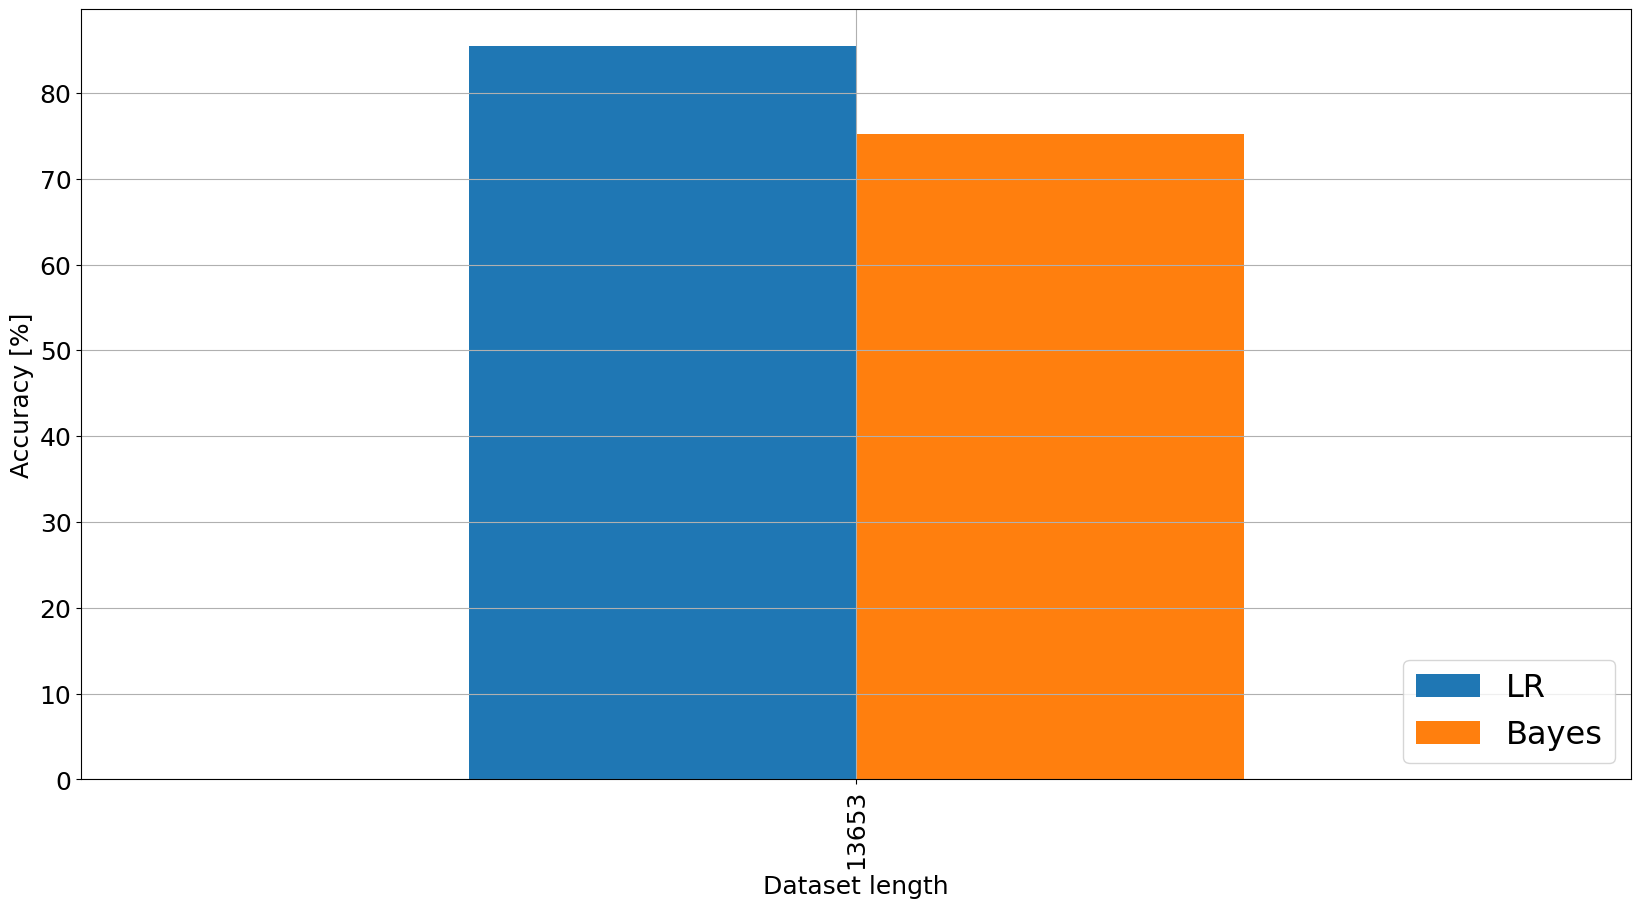

In [34]:
def plot_results(_results):
    plt.rcParams.update({'font.size': 18})
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.rc('legend', fontsize=23, loc='lower right')

    # unstack the dataframe
    _results.groupby(['max_no_texts', 'classifier_type']).accuracy.agg(['median']).unstack().plot(ax=ax, grid=True, kind='bar')
    ax.legend([ 'LR',  'Bayes'])
    ax.set_xlabel('Dataset length', size=18)
    ax.set_ylabel('Accuracy [%]', size=18)

plot_results(results)

In [35]:
print('dataset shape: {}'.format(df_preproc_balanced.shape))
print('bayes: {}'.format(accuracy_scores['bayes']))
print('logistic regression: {}'.format(accuracy_scores['lr']))

dataset shape: (13654, 2)
bayes: 75.21054558769681
logistic regression: 85.463200292933


<h3>3.4. Test models</h3>

In [37]:
test_sample1 = 'Filmul este fantastic! Imi place foarte mult!'
test_sample2 = 'Filmul este groaznic! Nu l-as viziona!'
test_sample3 = 'Filmul este so-so. As merge mai degraba la teatru.'

data = {'text': [test_sample1, test_sample2, test_sample3], 'label': [-1, -1, -1]}
data_df = pd.DataFrame.from_dict(data)

counts = count_vectorizer.transform(data_df['text'])
text = transformer.transform(counts)

models['lr'].predict(text)

array([1, 0, 0], dtype=int64)

<h3>3.5. Model accuracy stats</h3>

In [38]:
print(classification_reports['lr'])
print(classification_reports['bayes'])

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1389
           1       0.85      0.85      0.85      1342

    accuracy                           0.85      2731
   macro avg       0.85      0.85      0.85      2731
weighted avg       0.85      0.85      0.85      2731

              precision    recall  f1-score   support

           0       0.79      0.70      0.74      1389
           1       0.72      0.80      0.76      1342

    accuracy                           0.75      2731
   macro avg       0.76      0.75      0.75      2731
weighted avg       0.76      0.75      0.75      2731



<h2>4. Neural Network based classifier</h2>

In [39]:
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU
from tensorflow.keras.layers import Embedding, BatchNormalization
from tensorflow.keras.initializers import Constant
from tensorflow.keras import optimizers
from tensorflow.keras.models import model_from_json

<h3>4.1. Word embedding</h3>

In [45]:
# join back words into strings
df_preproc_str = df_raw.copy()
df_preproc_str['text'] = df_preproc_str['text'].apply(lambda l: ' '.join(l))

In [46]:
# select a random subset of the texts
df_raw_sample = df_raw.copy()#sample(10000)

# split the model into train and test datasets
x_train, x_test, y_train, y_test = model_selection.train_test_split(df_raw_sample['text'], df_raw_sample['label'], test_size=0.2)

x_train = x_train.values
x_test = x_test.values

y_train = y_train.values
y_test = y_test.values

print(len(x_train) + len(x_test))

x_all = list(x_train) + list(x_test)

# define tokenizer object
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(x_all)

# store tokenizer obj to file
with open('tokenizer.obj', 'wb') as tokenizer_file:
    pickle.dump(tokenizer_obj, tokenizer_file)

# pad sequences
max_length = max([len(s.split()) for s in x_all])

print('max_length: {}'.format(max_length))

# define vocabulary size
vocab_size = len(tokenizer_obj.word_index) + 1

print('vocab_size: {}'.format(vocab_size))

x_train_tokens = tokenizer_obj.texts_to_sequences(x_train)
x_test_tokens = tokenizer_obj.texts_to_sequences(x_test)

x_train_pad = pad_sequences(x_train_tokens, maxlen=max_length, padding='post')
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_length, padding='post')

17652
max_length: 373
vocab_size: 52890


<h3>4.2. Build Model</h3>

In [47]:
EMBEDDING_DIM = 100

print('Started building model structure...')

rnn_model = Sequential()
rnn_model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
rnn_model.add(GRU(units=64, dropout=0.1, recurrent_dropout=0.1))
rnn_model.add(BatchNormalization())
rnn_model.add(Dense(1, activation='sigmoid'))

_optimizer = optimizers.RMSprop(learning_rate=0.01)

rnn_model.compile(loss='binary_crossentropy', optimizer=_optimizer,
              metrics=['accuracy'])

print('Done building model structure...')
print(rnn_model.summary())

Started building model structure...
Done building model structure...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 373, 100)          5289000   
                                                                 
 gru_1 (GRU)                 (None, 64)                31872     
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5321193 (20.30 MB)
Trainable params: 5321065 (20.30 MB)
Non-trainable params: 128 (512.00 Byte)
_________________________________________________________________
None


<h3>4.3. Train Model</h3>

In [48]:
%%time
print('Started training the model...')
early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = rnn_model.fit(x_train_pad, y_train, 
                        batch_size=32, 
                        epochs=100, 
                        validation_data=(x_test_pad, y_test), 
                        callbacks=[early_stopping],
                        verbose=2)
print('Done training the model...')

Started training the model...
Epoch 1/100
442/442 - 141s - loss: 0.4517 - accuracy: 0.7633 - val_loss: 0.3337 - val_accuracy: 0.8519 - 141s/epoch - 320ms/step
Epoch 2/100
442/442 - 137s - loss: 0.2143 - accuracy: 0.9188 - val_loss: 0.2783 - val_accuracy: 0.8833 - 137s/epoch - 311ms/step
Epoch 3/100
442/442 - 134s - loss: 0.0914 - accuracy: 0.9688 - val_loss: 0.3723 - val_accuracy: 0.8887 - 134s/epoch - 304ms/step
Epoch 4/100
442/442 - 119s - loss: 0.0476 - accuracy: 0.9841 - val_loss: 0.4761 - val_accuracy: 0.8839 - 119s/epoch - 270ms/step
Epoch 5/100
442/442 - 119s - loss: 0.0356 - accuracy: 0.9885 - val_loss: 0.4891 - val_accuracy: 0.8904 - 119s/epoch - 269ms/step
Epoch 6/100
442/442 - 118s - loss: 0.0243 - accuracy: 0.9923 - val_loss: 0.5515 - val_accuracy: 0.8924 - 118s/epoch - 266ms/step
Epoch 7/100
442/442 - 116s - loss: 0.0273 - accuracy: 0.9922 - val_loss: 0.4987 - val_accuracy: 0.8961 - 116s/epoch - 262ms/step
Epoch 8/100
442/442 - 116s - loss: 0.0222 - accuracy: 0.9926 - val_

<h3>4.4. Plot train history</h3>

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


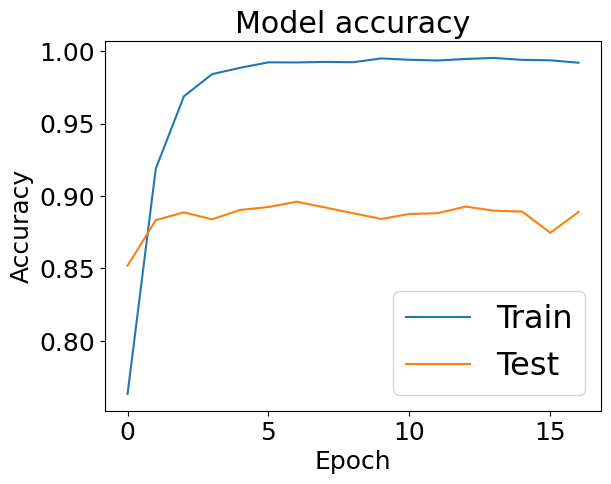

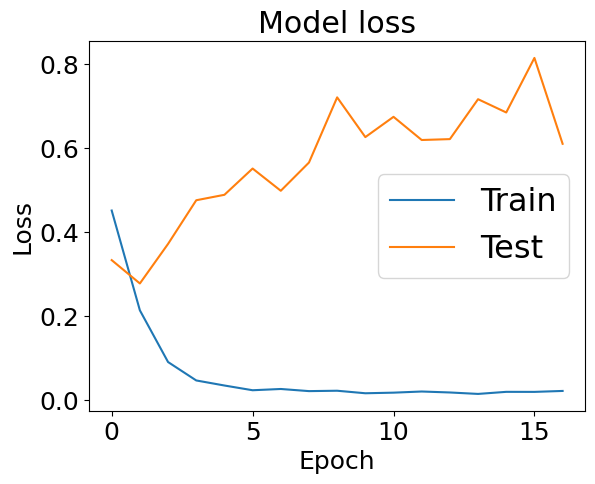

In [50]:
print(history.history.keys())

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='center right')
plt.show()

In [51]:
def store_model(_model, path='./', file_prefix='model_sentiment_rnn'):
    
    # serialize model to JSON
    model_json = _model.to_json()
    json_file_path = os.path.join(path, "{}.json".format(file_prefix))
    print('Started saving model JSON to {}'.format(json_file_path))
    assert os.path.exists(path)
    with open(json_file_path, "w+") as json_file:
        json_file.write(model_json)
    print("Done saving model JSON to {}".format(json_file_path))
    
    # serialize weights to HDF5
    weights_file_path = os.path.join(path, '{}.h5'.format(file_prefix))
    print("Started saving model weights to {}".format(weights_file_path))
    _model.save_weights(weights_file_path)
    print("Done saving model weights to {}".format(weights_file_path))

def load_model(path='./', file_prefix='model_sentiment_rnn'):
    # load json and create model
    print('Started loading model from JSON file')
    with open('{}.json'.format(file_prefix), 'r') as json_file:
        loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)
    print('Done loading model from JSON file')
    
    # load weights into new model
    print("Starting loading model from disk")
    weights_file_path = os.path.join(path, '{}.h5'.format(file_prefix))
    assert os.path.exists(weights_file_path)
    loaded_model.load_weights(weights_file_path)
    print("Done loading model from disk from file: {}".format(weights_file_path))
    return loaded_model

# save model:
store_model(rnn_model)
# model = load_model()
# print(model)

Started saving model JSON to ./model_sentiment_rnn.json
Done saving model JSON to ./model_sentiment_rnn.json
Started saving model weights to ./model_sentiment_rnn.h5
Done saving model weights to ./model_sentiment_rnn.h5


<h3>4.5. Test Model</h3>

In [53]:
test_sample1 = 'Filmul este fantastic! Imi place foarte mult!'
test_sample2 = 'Filmul este spectaculos! Mi-a placut foarte, foarte mult!'
test_sample3 = 'Filmul a fost teribil. As merge mai degraba la teatru.'
test_sample4 = 'A fost un film plictisitor.'
test_sample5 = 'Filmul nu a fost preferatul meu'
test_sample6 = 'Sunt foarte multumita. '
test_sample7 = 'Nu m-a impresionat... a fost o pierdere de timp'
test_sample8 = 'Se putea mai bine, actorii nu au jucat bine'
test_sample9 = 'Cel mai bun film pe care l-am vazut anul acesta!'
test_sample10 = 'Un desen foarte bun pentru copii, fetitei mele i-a placut mult'
test_samples = [test_sample1, test_sample2, test_sample3, test_sample4, test_sample5, test_sample6, test_sample7, test_sample8, test_sample9, test_sample10]

test_samples_tokens = tokenizer_obj.texts_to_sequences(test_samples)
test_samples_tokens_pad = pad_sequences(test_samples_tokens, maxlen=max_length)

# predict
rnn_model.predict(x=test_samples_tokens_pad)

1/1 [==============================] - 0s 54ms/step


array([[9.9932003e-01],
       [9.9959946e-01],
       [4.0125436e-04],
       [4.5212739e-05],
       [2.9417428e-01],
       [9.9680287e-01],
       [7.8694836e-07],
       [2.0102850e-01],
       [9.9476677e-01],
       [9.7385615e-01]], dtype=float32)